# 00 Getting setup

In [266]:
import torch
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 00.1 Downloading the Data


In [267]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi
from pathlib import Path

os.environ['KAGGLE_CONFIG_DIR'] = 'C:\\Users\\loq\\.kaggle'

api = KaggleApi()
api.authenticate()

data_path = Path("data/")
audio_path = data_path / "Data"

dataset = 'andradaolteanu/gtzan-dataset-music-genre-classification'

if audio_path.is_dir():
    print("Data already exists, skipping dawnload...")
else:    
    print("Downloading data...")
    api.dataset_download_files(dataset, path=data_path, unzip=True)

Data already exists, skipping dawnload...


### 00.2 Walking through the directory

In [268]:
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} audios in {dirpath}")

In [269]:
genres_original_path = audio_path / 'genres_original'

walk_through_dir(genres_original_path)

There are 10 directories and 0 audios in data\Data\genres_original
There are 0 directories and 100 audios in data\Data\genres_original\blues
There are 0 directories and 100 audios in data\Data\genres_original\classical
There are 0 directories and 100 audios in data\Data\genres_original\country
There are 0 directories and 100 audios in data\Data\genres_original\disco
There are 0 directories and 100 audios in data\Data\genres_original\hiphop
There are 0 directories and 100 audios in data\Data\genres_original\jazz
There are 0 directories and 100 audios in data\Data\genres_original\metal
There are 0 directories and 100 audios in data\Data\genres_original\pop
There are 0 directories and 100 audios in data\Data\genres_original\reggae
There are 0 directories and 100 audios in data\Data\genres_original\rock


# Getting data ready

### Creating spectogram on a single sample 

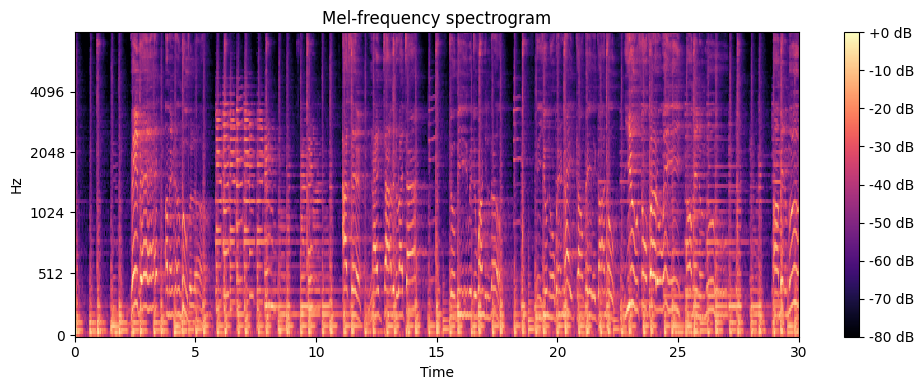

In [270]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

audio_path = 'data/Data/genres_original/blues/blues.00001.wav'

y, sr = librosa.load(audio_path, sr=22050)  # y — signal, sr — sample rate

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)

S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

In [271]:
y.shape, S.shape, S_dB.shape

((661794,), (128, 1293), (128, 1293))

In [272]:
import torchaudio
from torchaudio import transforms
from torch.utils.data import Dataset
from typing import Tuple, Dict, List

In [273]:
def find_classes(directory: Path):
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    if not classes:
        raise FileNotFoundError("Couldn't find any classes, please check file structure")
    class_to_idx = {class_name:i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [274]:
find_classes(genres_original_path)

(['blues',
  'classical',
  'country',
  'disco',
  'hiphop',
  'jazz',
  'metal',
  'pop',
  'reggae',
  'rock'],
 {'blues': 0,
  'classical': 1,
  'country': 2,
  'disco': 3,
  'hiphop': 4,
  'jazz': 5,
  'metal': 6,
  'pop': 7,
  'reggae': 8,
  'rock': 9})

In [275]:
class AudioFolderCustom(Dataset):
    def __init__(self,
                 targ_dir: Path,
                 target_length: int,
                 transform=None,
                 percentage: Tuple[int, int]= (0.0, 1.0),
                 ):
        
        super().__init__()
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(targ_dir)
        self.target_length = target_length
        all_paths = []
        targ_dir = Path(targ_dir)

        for cls_name in self.classes:
            cls_folder = targ_dir / cls_name
            wav_files = sorted(cls_folder.glob('*.wav'))
            start_files = int(len(wav_files) * percentage[0])
            end_files = int(len(wav_files) * percentage[1])
            selected_files = wav_files[start_files:end_files]
            all_paths.extend(selected_files)

        self.paths = all_paths
        

    def __len__(self):
        return len(self.paths) 

    def __getitem__(self, idx):
        filepath= self.paths[idx]
        class_name = filepath.parent.name
        class_idx = self.class_to_idx[class_name]
        waveform, sample_rate = torchaudio.load(filepath)
        if self.transform:
            waveform = self.transform(waveform)
        
        current_length = waveform.shape[2]
        #print(f"Current length: {current_length}")
        #print(f"Target length: {self.target_length}")
        if current_length > self.target_length:
            waveform = waveform[:, :, :self.target_length]
            #print(f"Waveform shape curr > targ: {waveform.shape}")
        elif current_length < self.target_length:
            pad_len = self.target_length - current_length
            waveform = torch.nn.functional.pad(waveform, (0, pad_len))
            #print(f"Waveform shape curr < targ: {waveform.shape}")


        return waveform, class_idx  

In [276]:
class FixAudioLength(nn.Module):
    def __init__(self, target_length: int):
        self.target_length = target_length

    def forward(self, waveform):
        current_length = waveform.shape[1]
        if current_length > self.target_length:
            return waveform[:, :self.target_length]
        elif current_length < self.target_length:
            pad_len = self.target_length - current_length
            return torch.nn.functional.pad(waveform, (0, pad_len))
        return waveform

tensor([[ 0.0034,  0.0043,  0.0014,  ..., -0.1195, -0.1750, -0.1512]])


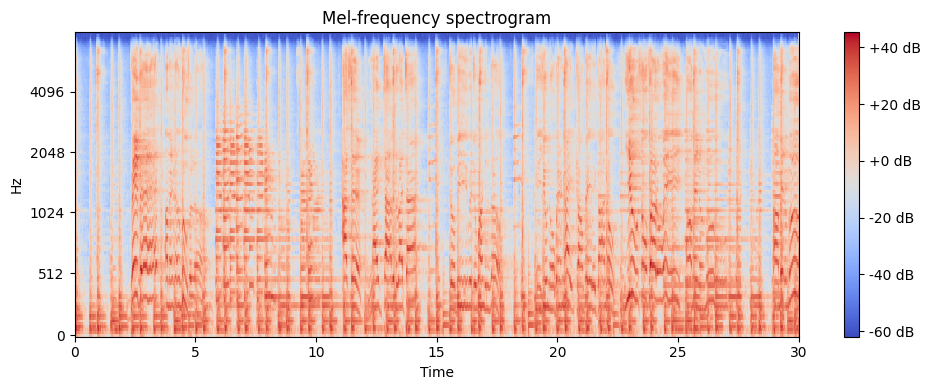

In [ ]:

target_length = 1293

train_transform = nn.Sequential(
    #FixAudioLength(target_length),
    transforms.MelSpectrogram(
        sample_rate=22050,
        n_fft=2048,
        hop_length=512,
        n_mels=128
    ),
    transforms.AmplitudeToDB()
)

test_transform = nn.Sequential(
    #FixAudioLength(target_length),
    transforms.MelSpectrogram(
    sample_rate=22050,
    n_fft=2048,
    hop_length=512,
    n_mels=128
    ),
    transforms.AmplitudeToDB()
)

waveform, sample_rate = torchaudio.load(audio_path)
print(waveform)
transformed_audio = train_transform(waveform)

plt.figure(figsize=(10, 4))
librosa.display.specshow(transformed_audio.squeeze().numpy(), sr=sample_rate, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()


In [278]:
train_data_custom = AudioFolderCustom(targ_dir=genres_original_path,
                                      target_length=target_length,
                                      transform=train_transform,
                                      percentage=(0.0, 0.4))

test_data_custom = AudioFolderCustom(targ_dir=genres_original_path,
                                     target_length=target_length,
                                     transform=test_transform,
                                     percentage=(0.4, 0.5))
train_data_custom, test_data_custom, len(train_data_custom), len(test_data_custom)

(<__main__.AudioFolderCustom at 0x2d12b145d00>,
 400,
 100)

In [279]:
train_data_custom.class_to_idx

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

In [280]:
train_data_custom[0]

(tensor([[[ 13.4828,   5.9640,   1.8562,  ...,   6.8329,  11.9825,  25.9314],
          [ 19.2457,  16.4810,  12.4256,  ...,  17.2989,  17.7044,  24.1307],
          [ 17.3070,  18.8685,  19.1816,  ...,  21.8041,  24.1712,  26.4650],
          ...,
          [-27.7707, -33.6933, -46.7951,  ..., -49.0790, -40.1361, -25.7201],
          [-27.7150, -33.7153, -56.1157,  ..., -56.8557, -42.5924, -25.7142],
          [-27.7529, -33.7639, -59.8251,  ..., -59.0783, -42.7502, -25.6456]]]),
 0)

In [281]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = 0

torch.manual_seed(19)
train_dataloader = DataLoader(dataset=train_data_custom,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_data_custom,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2d12b192ab0>,
 <torch.utils.data.dataloader.DataLoader at 0x2d12eace600>)

In [282]:
audio, label = next(iter(test_dataloader))
audio.shape, label.shape

(torch.Size([32, 1, 128, 1293]), torch.Size([32]))